<a href="https://colab.research.google.com/github/itallocastro/Qlearning/blob/main/cartPole_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 1s (244 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 157991 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import time
env = gym.make("CartPole-v0")

In [ ]:
# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

# Tile Coding

Limites do problema: 


1.   Position: [-4.8, 4.8]
2.   Cart Velocity: [-10, 10]
3.   Angular Velocity: [-10, 10]
4.   Angle: [-0.418, 0.418]


### Entendendo para uma dimensão

In [ ]:
def create_one_tiling(feat_range, bins, offset):
  return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset
def get_one_tiling(value, tiling):
  return  np.digitize(value, tiling)

In [ ]:
feat_range = [0, 1.0]
bins = 10
offset = 0.2
tiling = create_one_tiling(feat_range, bins, offset)
tiling

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

In [ ]:
get_one_tiling(1.2, tiling)

9

### Implementando o algoritmo

In [ ]:
def create_one_tiling(feat_range, bins, offset):
  return np.linspace(feat_range[0], feat_range[1], bins+1)[1:-1] + offset

In [ ]:
def create_tilings(features_range, tilings, bins, offsets):
  total_tilings = []
  for i in range(tilings):
    tiling_current = []
    bins_current = bins[i]
    offsets_current = offsets[i]
    # Para cada dimensão
    for j in range(len(features_range)):
      part_tiling = create_one_tiling(features_range[j], bins_current[j], offsets_current[j])
      tiling_current.append(part_tiling)
    total_tilings.append(tiling_current)
  return np.array(total_tilings)


In [ ]:
def discrete(state, bins):
  index = []
  for i in range(len(state)):
    index.append(
        np.digitize(state[i], bins[i])
    )
  return tuple(index)

In [ ]:
def get_tile(feature, tilings):
  tile_per_tiling = []
  for tiling in tilings:
    tile_per_tiling.append(discrete(feature, tiling))
  return np.array(tile_per_tiling)


In [ ]:
def create_weight(num_tilings, bins):
  matrices = []
  for i in range(num_tilings):
    matrices.append(np.zeros(tuple(bins[i])))
  return matrices

#### Testando

In [ ]:
feature_ranges = [[-1, 1], [-5, 5]]
number_tilings = 5
bins = [[10, 10], [10, 10], [10, 10], [10, 10], [10, 10]]
offsets = [[0, 0], [1, 1], [2, 2], [3, 3], [4,4]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
tilings.shape

(5, 2, 9)

### Exemplo

In [ ]:
def target_fn(x, y):
  return np.sin(x) + np.cos(y) + 0.1 * np.random.randn()

In [ ]:
bins = [[8, 8], [8, 8], [8, 8], [8, 8], [8, 8], [8, 8], [8, 8], [8, 8]]
feature_ranges = [(0.0, 2.0 * np.pi), (0.0, 2.0 * np.pi)]
number_tilings = 8
offsets = [[0., 0],
 [0.125, 0.375],
 [0.25 , 0.75 ],
 [0.375, 0.125],
 [0.5  , 0.5  ],
 [0.625 ,0.875],
 [0.75  ,0.25 ],
 [0.875 ,0.625]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)

In [ ]:
ws = create_weight(number_tilings, bins)
ws[0].shape

(8, 8)

In [ ]:
alpha = 0.1 / number_tilings
# learn from 10,000 samples
for i in range(10000):
   # get noisy sample from target function at random location
  x, y = 2.0 * np.pi * np.random.rand(2)
  target = target_fn(x, y)
  # get prediction from active tiles at that location
  tiles = get_tile([x, y], tilings)
  pred = 0
  for j in range(number_tilings):
    pred = pred + ws[j][tuple(tiles[j])]
  # update weights with SGD
  # print((pred))
  for j in range(number_tilings):
    ws[j][tuple(tiles[j])] += alpha * (target - pred)

In [ ]:
tiles = get_tile([2, 3.1], tilings)
pred = 0
for j in range(number_tilings):
  pred = pred + ws[j][tuple(tiles[j])]
pred

-0.09260942200817415

In [ ]:
np.sin(2) + np.cos(3.1)

-0.08983772344759777

# Q-learning

#### Criando os tilings para o Cart Pole

In [ ]:
def create_weight(num_tilings, bins):
  matrices = []
  for i in range(num_tilings):
    matrices.append(np.zeros(
        tuple(
            np.concatenate((bins[i], [2]))
          )))
  return matrices

In [ ]:
from random import random

In [ ]:
def generate_random_value(min, max):
  return min + (random() * (max - min))

In [ ]:
# def generate_offsets(num_tilings, feature_ranges):
#   step = [(feature[1] - feature[0])/num_tilings for feature in feature_ranges]
#   for i in range(num_tilings-1):
#     offset_dimension = []
#     for k in range()
#     for j in range(len(feature_ranges)):
#       offset_dimension.append()
#     offsets.append(offset_dimension)
#   return offsets

In [ ]:
def sum_weights(ws, current_state, action, number_tilings):
  total_sum = 0
  for j in range(number_tilings):
    state = tuple(np.concatenate((current_state[j], [action])))
    total_sum = total_sum + ws[j][state]
  return total_sum

In [ ]:
0.052375+ 0.0261875+0.0261875

0.10475

In [ ]:
# Position, velocity, angle, angular velocity
feature_ranges = [[-2.4, 2.4], [-5, 5], [-0.2095, 0.2095], [-5, 5]]
number_tilings = 4
step = [(feature[1] - feature[0])/number_tilings for feature in feature_ranges]
print(step)
bins = [[20, 20, 20, 20] for i in range(number_tilings)]
# 16 tilings
# offsets = [[0.0, 0.0],
#            [0.3, 0.0261875],
#            [-0.3, -0.0261875],
#            [-0.3, 0.0261875], 
#            [0.3, -0.0261875],
#            [0.6, 0.052375],
#            [-0.6, -0.052375],
#            [-0.6, 0.052375],
#            [0.6, -0.052375],
#            [0.9, 0.0785625],
#            [-0.9, -0.0785625],
#            [-0.9, 0.0785625],
#            [0.9, -0.0785625],
#            [1.2, 0.10475],
#            [-1.2, -0.10475],
#            [-1.2, 0.10475],
#            ]

# 8 tilings
# offsets = [[0.0, 0.0],
#            [0.6, 0.052375],
#            [-0.6, -0.052375],
#            [-0.6, 0.052375], 
#            [0.6, -0.052375],
#            [1.2, 0.10475],
#            [-1.2, -0.10475],
#            [-1.2, 0.10475],
#            ]

# 4 tilings 
offsets = [[0.0, 0.0, 0.0, 0.0],
           [1.2, 2.5, 0.10475, 2.5],
           [-1.2, -2.5, -0.10475, -2.5],
           [-1.2,  -2.5, 0.10475, 2.5], 
           ]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
tilings.shape

[1.2, 2.5, 0.10475, 2.5]


(4, 4, 19)

In [ ]:
get_tile([2.4, 0.2, 0.02, -1], tilings)

array([[29, 15, 16, 12],
       [22,  8,  8,  4],
       [29, 23, 23, 19],
       [29, 23,  8,  4]])

In [ ]:
ws = np.array(create_weight(number_tilings, bins))
ws.shape

(4, 20, 20, 20, 20, 2)

In [ ]:

def Q_Learning(ws, tilings, number_tilings,alpha = 0.1, gamma = 0.99, epsilon = 0.1, episodes = 20000):
  # alpha = alpha / number_tilings
  scores = []
  scores_per_100 = []
  for i in range(episodes):
    state = env.reset()
    # current_state = get_tile([state[0], state[2]], tilings)
    current_state = get_tile(state, tilings)
    done = False
    steps, score= 0, 0
    while not done:
      if(i % 100 == 0):
        pred_0 = sum_weights(ws, current_state, 0, number_tilings)
        pred_1 = sum_weights(ws, current_state, 1, number_tilings)
        action = 1 if pred_1 > pred_0 else 0
      else:
        if(np.random.uniform(0,1) < epsilon):
          action = env.action_space.sample()
        else:
          pred_0 = sum_weights(ws, current_state, 0, number_tilings)
          pred_1 = sum_weights(ws, current_state, 1, number_tilings)
          action = 1 if pred_1 > pred_0 else 0

      obs, reward, done, info = env.step(action)

      score += reward
      
      old_value = sum_weights(ws, current_state, action, number_tilings)

      # next_state = get_tile([obs[0], obs[2]], tilings)
      next_state = get_tile(obs, tilings)
      sum_next_0 = sum_weights(ws, next_state, 0, number_tilings)
      sum_next_1 = sum_weights(ws, next_state, 1, number_tilings)
      max_next = sum_next_0 if sum_next_0 > sum_next_1 else sum_next_1
      new_value = old_value + alpha * (reward + (gamma * max_next) - old_value)

      # print(f'i = {i} max value of next is {max_next}')
      k = 0
      coef = 0
      for j in range(number_tilings):
        coef += 1/(j+1)
      k = new_value/coef
      for j in range(number_tilings):
        ws[j][tuple(np.concatenate((current_state[j], [action])))] = k*(1/(j+1))

      current_state = next_state
      steps += 1
    if(i % 100 == 0):
      print(score)
      scores_per_100.append(score)
    if score > 190:
      print(f'Score {score} com {i} episódios')
    scores.append(score)

  return ws, scores, scores_per_100

In [ ]:
ws_updated, scores, scores_per_100 = Q_Learning(ws, tilings, number_tilings, episodes=20000)

A saída de streaming foi truncada nas últimas 5000 linhas.
Score 200.0 com 10845 episódios
Score 200.0 com 10846 episódios
Score 200.0 com 10847 episódios
Score 193.0 com 10849 episódios
Score 200.0 com 10851 episódios
Score 200.0 com 10852 episódios
Score 200.0 com 10853 episódios
Score 200.0 com 10854 episódios
Score 200.0 com 10855 episódios
Score 200.0 com 10856 episódios
Score 200.0 com 10872 episódios
Score 200.0 com 10875 episódios
Score 200.0 com 10876 episódios
Score 200.0 com 10877 episódios
Score 192.0 com 10878 episódios
Score 198.0 com 10879 episódios
Score 200.0 com 10880 episódios
Score 200.0 com 10884 episódios
Score 200.0 com 10886 episódios
Score 200.0 com 10893 episódios
Score 200.0 com 10896 episódios
Score 200.0 com 10897 episódios
Score 200.0 com 10898 episódios
Score 200.0 com 10899 episódios
200.0
Score 200.0 com 10900 episódios
Score 200.0 com 10904 episódios
Score 200.0 com 10906 episódios
Score 200.0 com 10907 episódios
Score 200.0 com 10910 episódios
Score 2

In [ ]:
import matplotlib.pyplot as plt


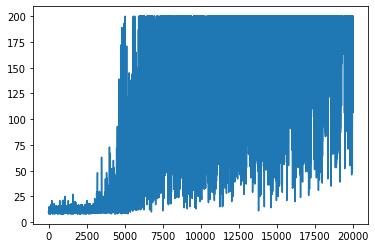

In [ ]:
plt.plot(range(0, len(scores)), scores)

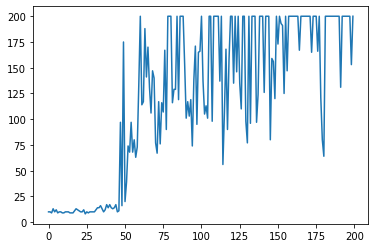

In [ ]:
plt.plot(range(0, len(scores_per_100)), scores_per_100)